# Image segmentation

The task is to train a simple deep learning model to segment the cells visible in wide fluorescence images. \
I decided too use a commenly U-Net architecture for that. 

I have use the folowing librarys.

<b> tensorflow.keras </b> for implementing the network, <b> os </b> and <b> matplotlib.image </b> to load the images, <b> numpy </b> and <b> skimage.transform </b> to reshape the images and last but not least <b> matplotlib.pyplot </b> to plot my results.

In [10]:
import tensorflow.keras as tf_k                              
import os                                                     
import matplotlib.image as img                               
import numpy as np                                           
from skimage.transform import downscale_local_mean as dlm    
import matplotlib.pyplot as plt                              
%matplotlib inline  

## Task 1: Download the data
 
I downloaded the images and put them in folders right next to the Python program. \
The folders are called <b>'Masks'</b> and <b>'Images'</b>. 

```
/ 
+--Masks 
+--Images 
+--Image_Segmentation.ipynb
```

## Task 2: Analyzing and pre-processing

Each dataset consisted of wide-field epifluorescence images of cultured neurons with both cytoplasmic (phalloidin) and nuclear staining (DAPI) and a set of manual segmentations of the neuronal and nuclear boundaries.
```
One Set:
    1x image with cytoplasmic (phalloidin) staining    size: 1040x1392x1
    1x image with nuclear staining                     size: 1040x1392x1
    up too 3 masks                                     size:  520x 696x3
```


As far as I can tell, all the masks are segmented from the images with the cytoplasmic (phalloidin) channel. 

<table><tr>
<td><img src="https://cildata.crbs.ucsd.edu/display_images/ccdb/ccdb_512/6843_512r.jpg" width="300px">
    <figcaption>
        Wide field fluorescent image of cultured neuroblastoma cells <br>
        labeled with phalloidn FITC (green) and DAPI (blue) nuclear stain.</td>
<td><img src="https://cildata.crbs.ucsd.edu/display_images/ccdb/ccdb_512/6843_512s.jpg" width="300px">
    <figcaption>
        Manual segmentation of cell and nuclear <br>
        boundaries of double labeled cultured neurons.</td>
</tr></table>

Therefore I decided to only use them to train my model.

Furthermore only a few of the images have 3 corresponding mask and some have only one. Becaus of that i only use one mask for image. \
That leaves me with 100 images and 100 masks.

The next step is to downsample the images and reshape the masks, so that they both have the same size of 520x696x1. \
This two task are done by the firs function. \
The function Looks through both folders, loads the images and brings the images and the masks into the right shape.

In [11]:
def load_training_images(foldername_1='Masks', foldername_2='Images'):
    masks = []
    FITC_images = []
    DAPI_images = []
    
    for filename in os.listdir(foldername_1):
        if "GT_01" in filename:
            masks.append(  img.imread(  os.path.join(foldername_1, filename))[:,:,0]   )
        else:
            pass

    for filename in os.listdir(foldername_2):
        if "w1" in filename:
            FITC_images.append( dlm( img.imread(  os.path.join(foldername_2, filename)  ), (2,2) )  )
        if "w2" in filename:
            DAPI_images.append( dlm( img.imread(  os.path.join(foldername_2, filename)  ), (2,2) )  )
        else:
            pass
    return masks, FITC_images, DAPI_images


load_masks, load_FITC_images, load_DAPI_images = load_training_images()



The next function, normalizes the data by dividing all values by the highest value. \
I use the highest value of all the images, not just the current one.

In [12]:
def Normalize(Liste):
    max_value = np.max(Liste)
    for k in range(len(Liste)):
        Liste[k] = Liste[k]/max_value
    return Liste

norm_masks       = Normalize(load_masks)
norm_FITC_images = Normalize(load_FITC_images)
norm_DAPI_images = Normalize(load_DAPI_images)



The last step is to divide the data in training and in testing data, and one last time to bring them in the right shape. \
I use 60 images for training and 40 for testing.

i noticed, that the images at the beginning have more cells in them than the latter images. Beacause of thet i take some from the front and some from the end for the training.


In [22]:
def get_data(masks, images_FITC, images_DAPI, size_train_data=60):
    
    masks_train       = np.array(masks).reshape(100,520,696,1)[:size_train_data]
    FITC_images_train = np.array(images_FITC).reshape(100,520,696,1)[:size_train_data]
    
    masks_test        = np.array(masks).reshape(100,520,696,1)[size_train_data:100]
    FITC_images_test  = np.array(images_FITC).reshape(100,520,696,1)[size_train_data:100]
    
    DAPI_images_test = np.array(images_DAPI).reshape(100,520,696,1)
    
    return masks_train, FITC_images_train, masks_test, FITC_images_test, DAPI_images_test


y_train, x_train, y_test, x_test, x2_test = get_data(norm_masks, norm_FITC_images, norm_DAPI_images)

## Task 3: The model

The architecture im uesing is a normal <b> U-Net architecture </b>, which i made a bit smaller than it is usually. \
I did this becaus becaus i got performanc problems while running the program. So i ended up uesing only two <b> channe sizes, 8 and 16 </b>. 

The shape of the data goes from <b>520x696x1</b> to <b>260x348x8</b> to <b>130x174x16</b> and then back again.
 
For the Optemizer i chose the <b> Adam </b> algorithm and my loss-function is the <b> BinaryCrossentropy </b>, as I only have to classes which I want to differentiate. \
I also use a <b>dropout of 10%</b> to prevent overfitting.

In [23]:
def get_model(chanels=[8, 16], drop_rate=0.1):

    inputs = tf_k.Input(shape=(520,696,1))                                       

    c1 = tf_k.layers.Conv2D(chanels[0], 3, activation='relu', padding="same")(inputs)
    c1 = tf_k.layers.Dropout(drop_rate)(c1)
    c1 = tf_k.layers.Conv2D(chanels[0], 3, activation='relu', padding="same")(c1)

    p1 = tf_k.layers.MaxPool2D((2,2))(c1)                                        

    c2 = tf_k.layers.Conv2D(chanels[1], 3, activation='relu', padding="same")(p1)
    c2 = tf_k.layers.Dropout(drop_rate)(c2)
    c2 = tf_k.layers.Conv2D(chanels[1], 3, activation='relu', padding="same")(c2)  

    p2 = tf_k.layers.MaxPool2D((2,2))(c2)                                        

    c3 = tf_k.layers.Conv2D(chanels[1], 3, activation='relu', padding="same")(p2)
    c3 = tf_k.layers.Dropout(drop_rate)(c3)
    c3 = tf_k.layers.Conv2D(chanels[1], 3, activation='relu', padding="same")(c3)

    u1 = tf_k.layers.Conv2DTranspose(16, 2, strides=2, padding="same")(c3)
    u1 = tf_k.layers.concatenate([c2,u1])

    c4 = tf_k.layers.Conv2D(chanels[1], 3, activation='relu', padding="same")(u1)
    c4 = tf_k.layers.Dropout(drop_rate)(c4)
    c4 = tf_k.layers.Conv2D(chanels[1], 3, activation='relu', padding="same")(c4)

    u2 = tf_k.layers.Conv2DTranspose(chanels[0], 2, strides=2, padding="same")(c4)
    u2 = tf_k.layers.concatenate([c1,u2])

    c5 = tf_k.layers.Conv2D(chanels[0], 3, activation='relu', padding="same")(u2)
    c5 = tf_k.layers.Dropout(drop_rate)(c5)
    c5 = tf_k.layers.Conv2D(chanels[0], 3, activation='relu', padding="same")(c5)


    outputs = tf_k.layers.Conv2D(1, 1, activation='sigmoid', padding="same")(c5) 
    
    return tf_k.Model(inputs=inputs, outputs=outputs)






Fro the trainig i use 70 sets of images and masks, in batches of 5 at a time with 3 epochs.

In [19]:
my_model = get_model()
my_model.compile(optimizer="Adam", loss="BinaryCrossentropy", metrics=["accuracy"])
my_model.fit(x_train, y_train, epochs=4, batch_size=5)



Epoch 1/3
14/14 [==============================] - 46s 3s/step - loss: 0.6804 - accuracy: 0.7242
Epoch 2/3
14/14 [==============================] - 45s 3s/step - loss: 0.5509 - accuracy: 0.7650
Epoch 3/3
14/14 [==============================] - 45s 3s/step - loss: 0.3271 - accuracy: 0.8821


Fro the testing i batches of 5, but this time only with 30 sets.

In [20]:
my_model.evaluate(x_test, y_test, batch_size=5)

6/6 [==============================] - 4s 600ms/step - loss: 0.1090 - accuracy: 0.9654


[0.10903657972812653, 0.9654126167297363]

## Task 4: Results
The model was run and it had an trainig error of 0.2455 and an accuracy of 91.07%.
The test error was approx. 0.069 while the accuracy was approx. 0.975.

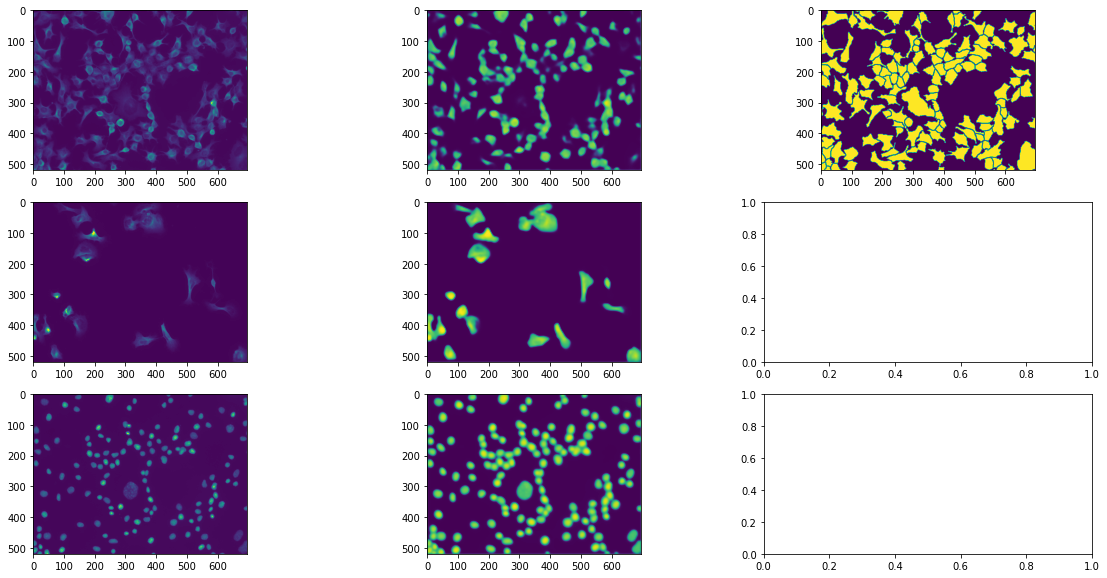

In [21]:
index = 8
prediction1 = my_model(x_test[index:index+1]).numpy()
prediction2 = my_model(x_train[index:index+1]).numpy()
prediction3 = my_model(x2_test[index:index+1]).numpy()





fig, ax = plt.subplots(3,3, figsize=(20,10))
ax[0][0].imshow(x_train[index])
ax[0][1].imshow(prediction2[0])
ax[0][2].imshow(y_train[index])


ax[1][0].imshow(x_test[index])
ax[1][1].imshow(prediction1[0])

ax[2][0].imshow(x2_test[index])
ax[2][1].imshow(prediction3[0])